In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

#from pandas_profiling import ProfileReportofileReport

import warnings
warnings.filterwarnings('ignore')

In [2]:
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import selection_rate, false_positive_rate,true_positive_rate,count


from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression,Lasso
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

from xgboost import XGBRegressor,XGBClassifier
import shap

from category_encoders.target_encoder import TargetEncoder
from category_encoders.m_estimate import MEstimateEncoder

from tqdm.notebook import tqdm

In [3]:
#pd.read_csv('propublica_data_for_fairml.csv').head()

In [4]:
df = pd.read_csv("data/compas-scores-raw.csv")

df["Score"] = df["DecileScore"]

# df.loc[df["DecileScore"] > 7, "Score"] = 2
# df.loc[(df["DecileScore"] > 4) & (df["DecileScore"] < 8), "Score"] = 1
# df.loc[df["DecileScore"] < 5, "Score"] = 0

df.loc[df["DecileScore"] > 4, "Score"] = 1
df.loc[df["DecileScore"] <= 4, "Score"] = 0


cols = [
    "Person_ID",
    "AssessmentID",
    "Case_ID",
    "LastName",
    "FirstName",
    "MiddleName",
    "DateOfBirth",
    "ScaleSet_ID",
    "Screening_Date",
    "RecSupervisionLevel",
    "Agency_Text",
    "AssessmentReason",
    "Language",
    "Scale_ID",
    "IsCompleted",
    "IsDeleted",
    "AssessmentType",
    "DecileScore",
]


df = df.drop(columns=cols)

possible_targets = ["RawScore", "ScoreText", "Score"]

X = df.drop(columns=possible_targets)
y = df[["Score"]]

In [5]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.33, random_state=42)

In [6]:
te = TargetEncoder()
model = XGBClassifier()
pipe = Pipeline([('encoder', te), ('model', model)])

pipe.fit(X_tr,y_tr)

preds = pipe.predict(X_te)



[17:09:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [7]:
explainer = shap.TreeExplainer(pipe.named_steps["model"])
shap_values = explainer.shap_values(pipe[:-1].transform(X_tr))


In [8]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [9]:
gm = MetricFrame(
    metrics=accuracy_score,
    y_true=y_te,
    y_pred=preds,
    sensitive_features=X_te["Sex_Code_Text"],
)
print(gm.overall)
print(gm.by_group)

gm = MetricFrame(
    metrics=accuracy_score,
    y_true=y_te,
    y_pred=preds,
    sensitive_features=X_te["Ethnic_Code_Text"],
)

print(gm.by_group)

gm = MetricFrame(
    metrics=accuracy_score,
    y_true=y_te,
    y_pred=preds,
    sensitive_features=X_te["RecSupervisionLevelText"],
)

print(gm.by_group)

0.8491956770755515
Sex_Code_Text
Female    0.856553
Male      0.847157
Name: accuracy_score, dtype: object
Ethnic_Code_Text
African-Am          0.916667
African-American    0.825278
Arabic                 0.875
Asian               0.927928
Caucasian           0.854845
Hispanic            0.889562
Native American     0.842105
Oriental                 1.0
Other               0.905437
Name: accuracy_score, dtype: object
RecSupervisionLevelText
High                                  0.867452
Low                                   0.891967
Medium                                0.744133
Medium with Override Consideration    0.771037
Name: accuracy_score, dtype: object


In [10]:
def fit_predict(modelo, enc, data, target, test):
    pipe = Pipeline([("encoder", enc), ("model", modelo)])
    pipe.fit(data, target)
    return pipe.predict(test)

In [11]:
gms = []
gms_rec = []
ms = []

param = [0, 1, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10_000]
# np.linspace(0,X_tr.shape[0],20)
for m in tqdm(param):
    encoder = MEstimateEncoder(m=m)
    model = LogisticRegression()
    #model = GradientBoostingClassifier()

    preds = fit_predict(modelo=model, enc=encoder, data=X_tr, target=y_tr, test=X_te)
    gm = MetricFrame(
        metrics=selection_rate,
        y_true=y_te,
        y_pred=preds,
        sensitive_features=X_te["Ethnic_Code_Text"],
    )
    gm_rec = MetricFrame(
        metrics=selection_rate,
        y_true=y_te,
        y_pred=preds,
        sensitive_features=X_te["RecSupervisionLevelText"],
    )

    gms.append(gm)
    gms_rec.append(gm_rec)
    ms.append(m)

  0%|          | 0/12 [00:00<?, ?it/s]

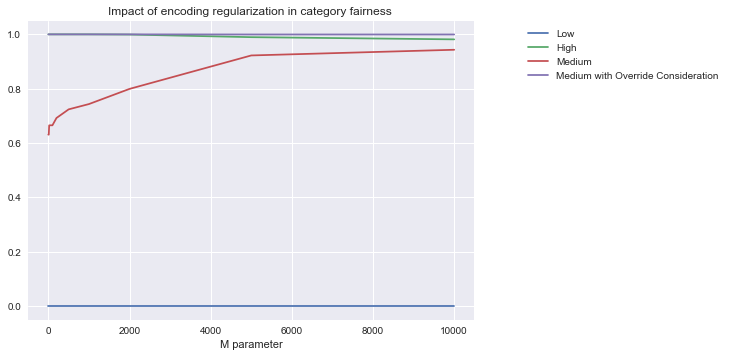

In [12]:
plt.figure()
plt.title('Impact of encoding regularization in category fairness ')
plt.xlabel('M parameter')
plt.plot(ms,[gm.by_group['Low'] for gm in gms_rec],label='Low')
plt.plot(ms,[gm.by_group['High'] for gm in gms_rec],label='High')
plt.plot(ms,[gm.by_group['Medium'] for gm in gms_rec],label='Medium')
plt.plot(ms,[gm.by_group['Medium with Override Consideration'] for gm in gms_rec],label='Medium with Override Consideration')

plt.legend(bbox_to_anchor=(1.1, 1))
plt.show()

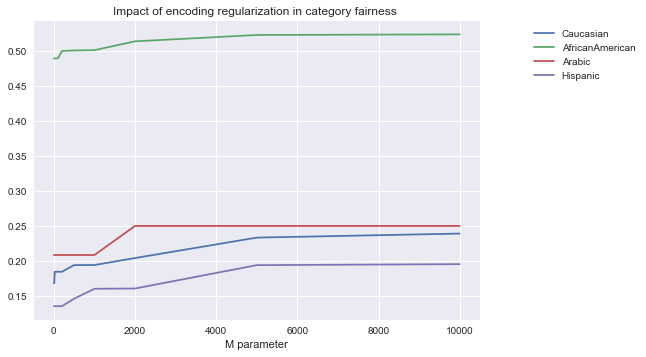

In [13]:
plt.figure()
plt.title('Impact of encoding regularization in category fairness ')
plt.xlabel('M parameter')
plt.plot(ms,[gm.by_group['Caucasian'] for gm in gms],label='Caucasian')
plt.plot(ms,[gm.by_group['African-American'] for gm in gms],label='AfricanAmerican')
plt.plot(ms,[gm.by_group['Arabic'] for gm in gms],label='Arabic')
plt.plot(ms,[gm.by_group['Hispanic'] for gm in gms],label='Hispanic')
#plt.plot(ms,[gm.by_group['Oriental'] for gm in gms],label='Oriental')
plt.legend(bbox_to_anchor=(1.1, 1))
plt.show()

  0%|          | 0/12 [00:00<?, ?it/s]

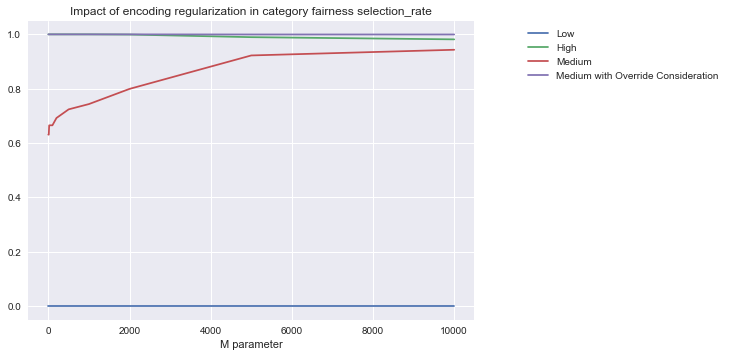

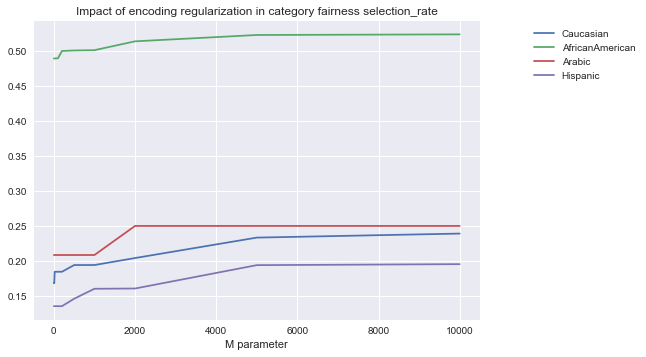

  0%|          | 0/12 [00:00<?, ?it/s]

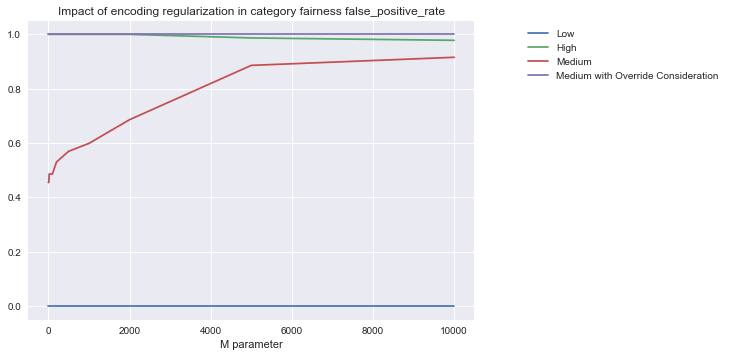

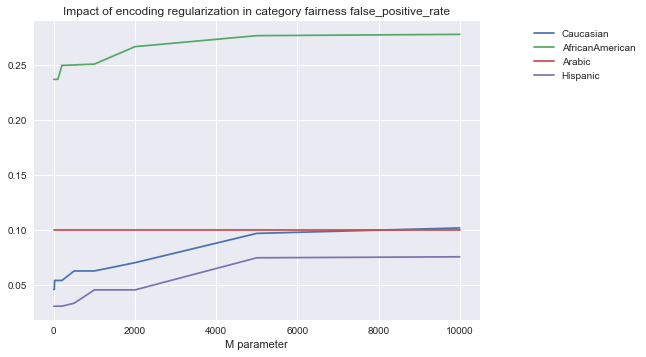

  0%|          | 0/12 [00:00<?, ?it/s]

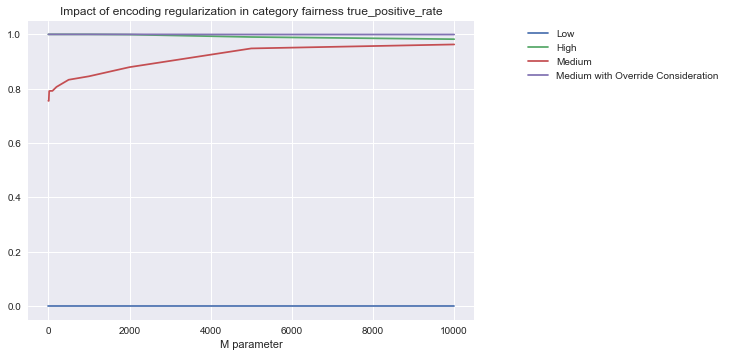

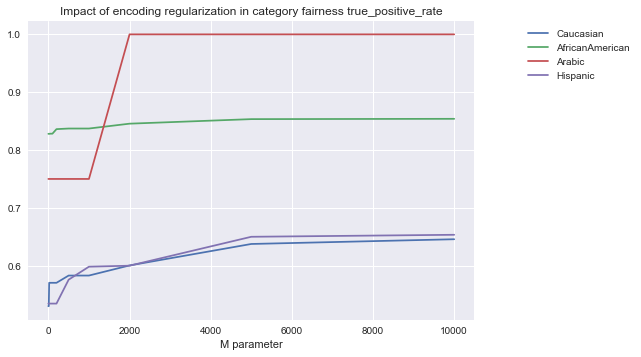

  0%|          | 0/12 [00:00<?, ?it/s]

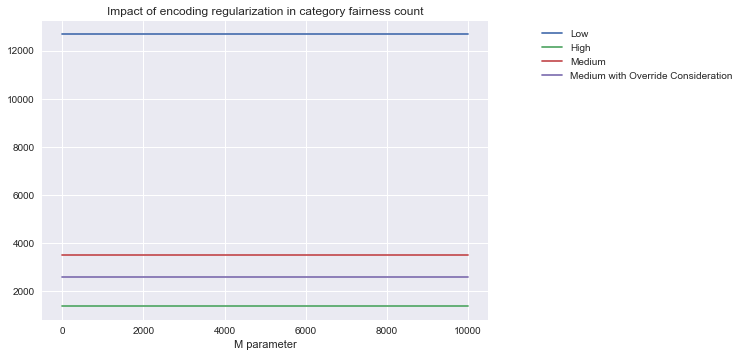

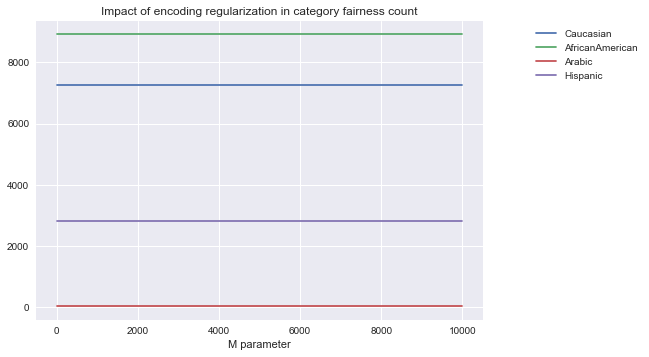

In [14]:
for metrics in [selection_rate, false_positive_rate,true_positive_rate,count]:
    gms = []
    gms_rec = []
    ms = []

    param = [0, 1, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10_000]
    # np.linspace(0,X_tr.shape[0],20)
    for m in tqdm(param):
        encoder = MEstimateEncoder(m=m)
        model = LogisticRegression()
        #model = GradientBoostingClassifier()

        preds = fit_predict(modelo=model, enc=encoder, data=X_tr, target=y_tr, test=X_te)
        gm = MetricFrame(
            metrics=metrics,
            y_true=y_te,
            y_pred=preds,
            sensitive_features=X_te["Ethnic_Code_Text"],
        )
        gm_rec = MetricFrame(
            metrics=metrics,
            y_true=y_te,
            y_pred=preds,
            sensitive_features=X_te["RecSupervisionLevelText"],
        )

        gms.append(gm)
        gms_rec.append(gm_rec)
        ms.append(m)

    plt.figure()
    title = 'Impact of encoding regularization in category fairness ' + str(metrics.__name__)
    plt.title(title)
    plt.xlabel('M parameter')
    plt.plot(ms,[gm.by_group['Low'] for gm in gms_rec],label='Low')
    plt.plot(ms,[gm.by_group['High'] for gm in gms_rec],label='High')
    plt.plot(ms,[gm.by_group['Medium'] for gm in gms_rec],label='Medium')
    plt.plot(ms,[gm.by_group['Medium with Override Consideration'] for gm in gms_rec],label='Medium with Override Consideration')

    plt.legend(bbox_to_anchor=(1.1, 1))
    plt.show()

    plt.figure()
    title = 'Impact of encoding regularization in category fairness ' + str(metrics.__name__)
    plt.title(title)
    plt.xlabel('M parameter')
    plt.plot(ms,[gm.by_group['Caucasian'] for gm in gms],label='Caucasian')
    plt.plot(ms,[gm.by_group['African-American'] for gm in gms],label='AfricanAmerican')
    plt.plot(ms,[gm.by_group['Arabic'] for gm in gms],label='Arabic')
    plt.plot(ms,[gm.by_group['Hispanic'] for gm in gms],label='Hispanic')
    #plt.plot(ms,[gm.by_group['Oriental'] for gm in gms],label='Oriental')
    plt.legend(bbox_to_anchor=(1.1, 1))
    plt.show()

In [15]:
kk

NameError: name 'kk' is not defined

# Other Data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
data = fetch_openml(data_id=1590, as_frame=True)
X = pd.get_dummies(data.data)
y_true = (data.target == '>50K') * 1
sex = data.data['sex']
sex.value_counts()

In [ ]:
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

In [ ]:
classifier = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)
classifier.fit(X, y_true)
DecisionTreeClassifier()
y_pred = classifier.predict(X)
gm = MetricFrame(metrics=accuracy_score, y_true=y_true, y_pred=y_pred, sensitive_features=sex)

In [ ]:
data.data['sex']